In [3]:
import pandas as pd
import re
import string

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN, KMeans
from sklearn.decomposition import TruncatedSVD, NMF
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import confusion_matrix

from nltk.corpus import stopwords, wordnet, words
from nltk.tokenize import PunktSentenceTokenizer, MWETokenizer, sent_tokenize, word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.chunk import ne_chunk
from nltk.tag import pos_tag

from textblob import TextBlob
import seaborn as sns
from scipy.cluster.hierarchy import dendrogram, linkage
from pprint import pprint
from pymongo import MongoClient
import matplotlib.pyplot as plt
%matplotlib inline 

In [4]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('maxent_ne_chunker')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/markdziuban/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/markdziuban/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /Users/markdziuban/nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!


True

In [5]:
merged_df = pd.read_csv('wot_clean.csv')

In [6]:
vectorizer2 = TfidfVectorizer(ngram_range=(1,5))
doc_word2 = vectorizer2.fit_transform(merged_df['POS_String'])
doc_word2.shape


(674, 634109)

In [7]:
# Initialize SVD Model

lsa2 = TruncatedSVD(3)
doc_topic2 = lsa2.fit_transform(doc_word2)
lsa2.explained_variance_ratio_

array([0.01026125, 0.05860954, 0.03379872])

### Topic modeling with sentence structure ONLY.

In [8]:
topic_word = pd.DataFrame(lsa2.components_.round(3),
             index = ["component_1","component_2","component_3"],
             #index = ["component_1","component_2"],
             columns = vectorizer2.get_feature_names())
topic_word

,cc,cc cc,cc cc cc,cc cc cc dt,cc cc cc dt nn,cc cc cc nn,cc cc cc nn nn,cc cc cd,cc cc cd nns,cc cc cd nns in,...,wrb wrb vbp prp vb,wrb wrb vbz,wrb wrb vbz dt,wrb wrb vbz dt nn,wrb wrb wp,wrb wrb wp vbd,wrb wrb wp vbd vb,wrb wrb wrb,wrb wrb wrb vbd,wrb wrb wrb vbd prp
component_1,0.101,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
component_2,0.019,-0.0,0.0,0.0,0.0,-0.0,-0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0
component_3,-0.220,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,0.0,0.0,...,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0


In [9]:
Vt2 = pd.DataFrame(doc_topic2.round(5),
             index = merged_df[['Book_Title','Chapter_Number']],
             columns = ["component_1","component_2","component_3"])
             #columns = ["component_1","component_2"])
Vt2

,component_1,component_2,component_3
"(01 The Eye of the World, 0)",0.95040,0.06001,0.01545
"(01 The Eye of the World, 1)",0.97623,0.10010,-0.02096
"(01 The Eye of the World, 2)",0.97192,0.02794,-0.02567
"(01 The Eye of the World, 3)",0.97257,0.02799,0.00304
"(01 The Eye of the World, 4)",0.97154,0.04135,0.01192
...,...,...,...
"(14 A Memory of Light, 48)",0.92314,0.07922,0.11993
"(14 A Memory of Light, 49)",0.88011,0.07233,0.07470
"(14 A Memory of Light, 50)",0.98026,-0.03331,0.04199
"(RobertJordan, 0)",0.92998,0.13997,-0.00500


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

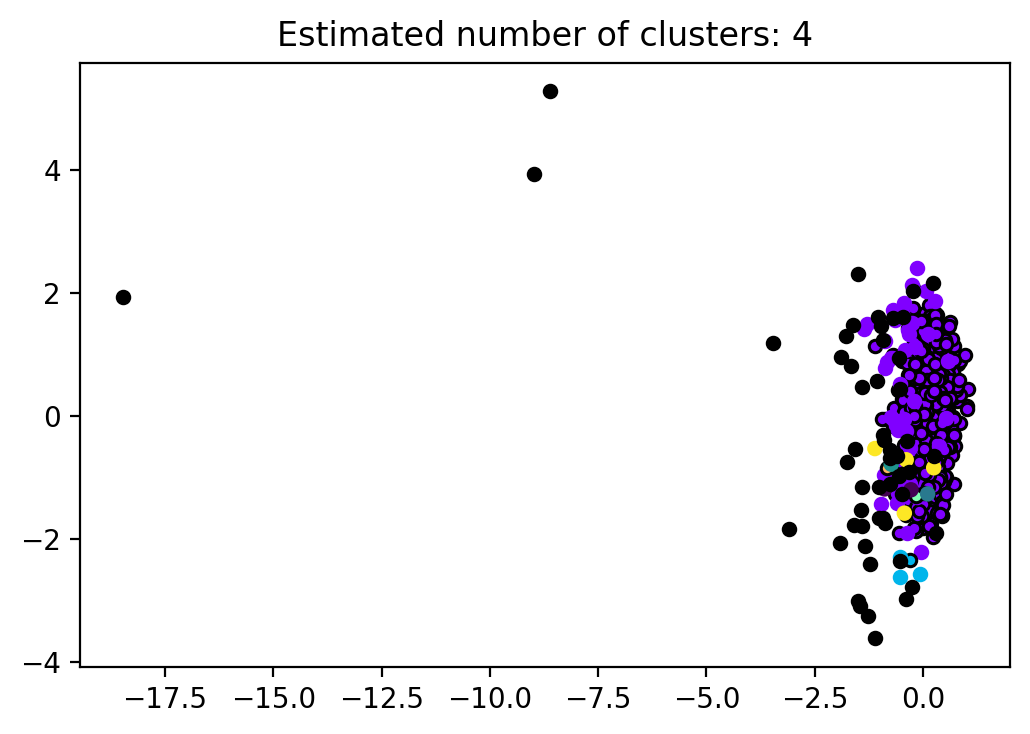

In [10]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
# Standardize our data for DBSCAN and fit DBSCAN
X = StandardScaler().fit_transform(Vt2)
db = DBSCAN(eps=.5,min_samples=5).fit(X)

# Let's find the observations DBSCAN called "core"
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

unique_labels = set(labels)
colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_labels)))
plt.figure(dpi=200)
show_core = True
show_non_core = True
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = 'k'

    class_member_mask = (labels == k)
    if show_core:
        xy = X[class_member_mask & core_samples_mask]
        x, y = xy[:,0], xy[:,1]
        plt.scatter(x, y, c=col, edgecolors='k',  s=20, linewidths=1.1) # add black border for core points
    
    if show_non_core:
        xy = X[class_member_mask & ~core_samples_mask]
        x, y = xy[:,0], xy[:,1]
        plt.scatter(x, y, c=col, s=20, linewidths=1.1)

plt.title('Estimated number of clusters: %d' % n_clusters_);

In [11]:
def display_cluster(X,km=[],num_clusters=0):
    color = 'brgcmyk'
    alpha = 0.5
    s = 20
    if num_clusters == 0:
        plt.scatter(X[:,0],X[:,1],c = color[0],alpha = alpha,s = s)
    else:
        for i in range(num_clusters):
            plt.scatter(X[km.labels_==i,0],X[km.labels_==i,1],c = color[i],alpha = alpha,s=s)
            plt.scatter(km.cluster_centers_[i][0],km.cluster_centers_[i][1],c = color[i], marker = 'x', s = 100)

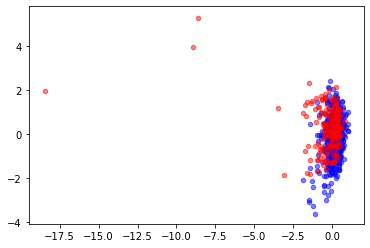

In [12]:
from sklearn.cluster import KMeans

num_clusters = 2
km = KMeans(n_clusters=num_clusters)
km.fit(X)
display_cluster(X,km,num_clusters)

In [13]:
from scipy.cluster.hierarchy import dendrogram, linkage

Z = linkage(X, method='ward')
plt.figure(figsize=(20,50), dpi=300)
dendrogram(Z,orientation='right'); 
plt.savefig('dendro2.pdf')

### Topic modeling and analysis with sentence structure and other features

In [14]:
# Add the main character stop words since they are a very common occurrance.
stopwords = nltk.corpus.stopwords.words('english')
newStopWords = ['mat','egwene','rand','perrin','nynaeve','elayne']
stopwords.extend(newStopWords)

In [16]:
vectorizer = TfidfVectorizer(ngram_range=(1, 3),max_df=.8,min_df = .05, stop_words=stopwords)
doc_word = vectorizer.fit_transform(merged_df['Chapter_Text'])
doc_word.shape

(674, 6763)

In [17]:
lsa = TruncatedSVD(3)
doc_topic = lsa.fit_transform(doc_word)
lsa.explained_variance_ratio_

array([0.00604316, 0.03038009, 0.02482368])

In [18]:
topic_word = pd.DataFrame(lsa.components_.round(3),
             index = ["component_1","component_2","component_3"],
             #index = ["component_1","component_2"],
             columns = vectorizer.get_feature_names())
topic_word


,aback,abandon,abandoned,abashed,abilities,ability,able,able channel,able make,able see,...,young women,younger,youngest,youre,youre going,youth,youve,youve done,youwere,youwill
component_1,0.003,0.006,0.009,0.003,0.004,0.010,0.029,0.004,0.003,0.003,...,0.005,0.012,0.003,0.030,0.005,0.006,0.019,0.004,0.003,0.004
component_2,0.000,0.001,-0.004,-0.002,0.004,0.009,0.007,0.004,-0.001,-0.000,...,0.004,-0.000,0.003,-0.001,-0.001,0.000,0.006,0.000,-0.000,0.002
component_3,0.001,0.004,0.002,-0.002,0.000,0.000,0.008,0.001,0.001,0.002,...,-0.002,0.003,-0.000,-0.014,-0.001,0.000,-0.008,0.002,-0.001,-0.000


In [19]:
def display_topics(model, feature_names, no_top_words, topic_names=None):
    for ix, topic in enumerate(model.components_):
        if not topic_names or not topic_names[ix]:
            print("\nTopic ", ix)
        else:
            print("\nTopic: '",topic_names[ix],"'")
        print(", ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

In [20]:
display_topics(lsa, vectorizer.get_feature_names(), 16)


Topic  0
moiraine, aviendha, faile, aiel, min, lord, lan, tower, birgitte, siuan, thom, loial, room, trollocs, wise, stone

Topic  1
siuan, sheriam, elaida, amyrlin, tower, bryne, leane, lelaine, romanda, gawyn, sisters, sitters, hall, birgitte, novices, ajah

Topic  2
aviendha, faile, aiel, wise, wise ones, amys, rhuarc, ones, shaido, maidens, berelain, cadsuane, bair, gaishain, birgitte, sorilea


In [21]:
mean_sent_len = list(merged_df['Mean_Sent_Length'].round(3))

In [22]:
num_of_sent = list(merged_df['Num_Sent'])

In [26]:
Vt = pd.DataFrame(doc_topic.round(5),
             index = merged_df[['Book_Title','Chapter_Number']],
             columns = ["Dragon_Reborn","Aes_Sedai","Aiel"])
             #columns = ["component_1","component_2"])
Vt['Mean_Sent_Len'] = mean_sent_len
Vt['Sent_per_Chap'] = num_of_sent
Vt['component_1'] = Vt2['component_1']
Vt['component_2'] = Vt2['component_2']
Vt['component_3'] = Vt2['component_3']

In [27]:
Vt

,Dragon_Reborn,Aes_Sedai,Aiel,Mean_Sent_Len,Sent_per_Chap,component_1,component_2,component_3
"(01 The Eye of the World, 0)",0.27424,-0.04285,0.00612,13.124,193,0.95040,0.06001,0.01545
"(01 The Eye of the World, 1)",0.32246,-0.11360,-0.13480,15.086,443,0.97623,0.10010,-0.02096
"(01 The Eye of the World, 2)",0.39387,-0.09274,-0.19390,13.728,338,0.97192,0.02794,-0.02567
"(01 The Eye of the World, 3)",0.32631,-0.07576,-0.12356,14.083,360,0.97257,0.02799,0.00304
"(01 The Eye of the World, 4)",0.33974,-0.10316,-0.19922,14.176,398,0.97154,0.04135,0.01192
...,...,...,...,...,...,...,...,...
"(14 A Memory of Light, 48)",0.27506,-0.12381,0.16441,8.316,177,0.92314,0.07922,0.11993
"(14 A Memory of Light, 49)",0.21204,0.01039,0.07484,8.286,93,0.88011,0.07233,0.07470
"(14 A Memory of Light, 50)",0.51121,-0.17245,0.04696,8.551,900,0.98026,-0.03331,0.04199
"(RobertJordan, 0)",0.33945,0.29042,-0.11727,14.458,180,0.92998,0.13997,-0.00500


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

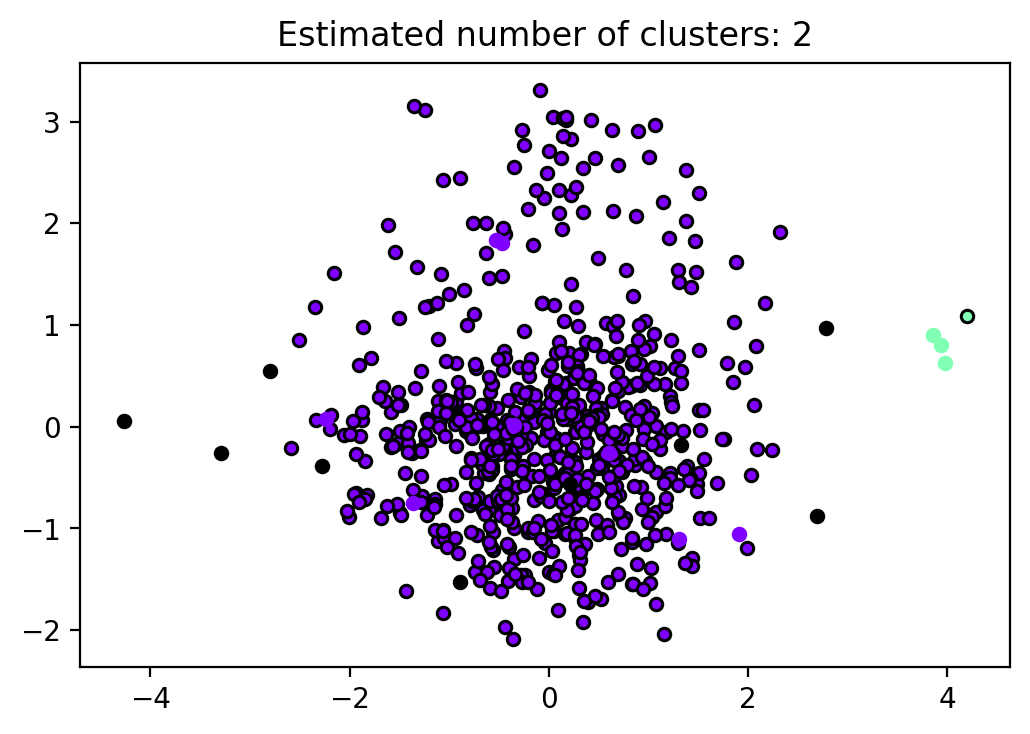

In [44]:

# Standardize our data for DBSCAN and fit DBSCAN
X = StandardScaler().fit_transform(Vt)
db = DBSCAN(eps=2,min_samples=3).fit(X)

# Let's find the observations DBSCAN called "core"
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

unique_labels = set(labels)
colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_labels)))
plt.figure(dpi=200)
show_core = True
show_non_core = True
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = 'k'

    class_member_mask = (labels == k)
    if show_core:
        xy = X[class_member_mask & core_samples_mask]
        x, y = xy[:,0], xy[:,1]
        plt.scatter(x, y, c=col, edgecolors='k',  s=20, linewidths=1.1) # add black border for core points
    
    if show_non_core:
        xy = X[class_member_mask & ~core_samples_mask]
        x, y = xy[:,0], xy[:,1]
        plt.scatter(x, y, c=col, s=20, linewidths=1.1)

plt.title('Estimated number of clusters: %d' % n_clusters_);

In [45]:
def display_cluster(X,km=[],num_clusters=0):
    color = 'brgcmyk'
    alpha = 0.5
    s = 20
    if num_clusters == 0:
        plt.scatter(X[:,0],X[:,1],c = color[0],alpha = alpha,s = s)
    else:
        for i in range(num_clusters):
            plt.scatter(X[km.labels_==i,0],X[km.labels_==i,1],c = color[i],alpha = alpha,s=s)
            plt.scatter(km.cluster_centers_[i][0],km.cluster_centers_[i][1],c = color[i], marker = 'x', s = 100)

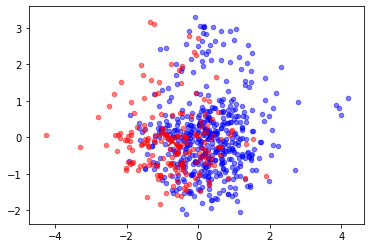

In [46]:
num_clusters = 2
km = KMeans(n_clusters=num_clusters)
km.fit(X)
display_cluster(X,km,num_clusters)
plt.savefig('wot_kmeans.pdf')

In [47]:
cluster_map = pd.DataFrame()
cluster_map['data_index'] = merged_df.index
cluster_map['cluster'] = km.labels_

In [48]:
# Looking at the last rows to see if they match up with the rows for Brandon Sanderson (>500)
cluster_map['cluster'][630:640]

630    1
631    1
632    1
633    1
634    0
635    1
636    1
637    1
638    1
639    1
Name: cluster, dtype: int32

In [49]:
# Create the dendrogram

Z = linkage(X, method='ward')
plt.figure(figsize=(20,50), dpi=300)
dendrogram(Z,orientation='right'); 
plt.savefig('dendro.pdf')

In [63]:
merged_df['0_for_Jordan'] = 0

In [64]:
def one_for_jordan(title):
    if title == '12 The Gathering Storm':
        return 1
    if title == '13 Towers of Midnight':
        return 1
    if  title=='14 A Memory of Light':
        return 1
    if title=='BrandonSandersonExtra':
        return 1
    else:
        return 0

In [65]:
merged_df['0_for_Jordan'] = merged_df['Book_Title'].apply(one_for_jordan)
merged_df

,Book_Chap,Book_Title,Chapter_Text,Chapter_Number,Chap_by_Sent,Word_Tokens,POV,Mean_Sent_Length,Num_Sent,Parts_of_Speech,POS_String,1_for_Jordan,Kmeans,0_for_Jordan
0,01 The Eye of the World 0,01 The Eye of the World,prologue dragonmountthe palace still shook occ...,0,['prologue dragonmountthe palace still shook o...,"[['prologue', 'dragonmountthe', 'palace', 'sti...",Not_Main,13.123711,193,"[['NN', 'NN', 'NN', 'RB', 'VBD', 'RB', 'IN', '...","NN NN NN RB VBD RB IN DT NN VBD IN NN , VBN I...",1,1,0
1,01 The Eye of the World 1,01 The Eye of the World,"an empty roadthe wheel of time turns , and age...",1,"['an empty roadthe wheel of time turns , and a...","[['an', 'empty', 'roadthe', 'wheel', 'of', 'ti...",rand,15.086393,443,"[['DT', 'JJ', 'NN', 'NN', 'IN', 'NN', 'NNS', '...","DT JJ NN NN IN NN NNS , CC VBZ VBN CC NN , VB...",1,0,0
2,01 The Eye of the World 2,01 The Eye of the World,strangerswhen rand and mat carried the first b...,2,['strangerswhen rand and mat carried the first...,"[['strangerswhen', 'rand', 'and', 'mat', 'carr...",rand,13.728045,338,"[['NN', 'NN', 'CC', 'NN', 'VBD', 'DT', 'JJ', '...","NN NN CC NN VBD DT JJ NNS IN DT JJ NN , NN RB...",1,0,0
3,01 The Eye of the World 3,01 The Eye of the World,the peddlerclusters of pots clattered and bang...,3,['the peddlerclusters of pots clattered and ba...,"[['the', 'peddlerclusters', 'of', 'pots', 'cla...",rand,14.082873,360,"[['DT', 'NNS', 'IN', 'NNS', 'VBN', 'CC', 'VBN'...",DT NNS IN NNS VBN CC VBN IN DT NNS WDT VBD IN...,1,0,0
4,01 The Eye of the World 4,01 The Eye of the World,the gleemanthe door of the inn banged shut beh...,4,['the gleemanthe door of the inn banged shut b...,"[['the', 'gleemanthe', 'door', 'of', 'the', 'i...",rand,14.175610,398,"[['DT', 'JJ', 'NN', 'IN', 'DT', 'NN', 'VBD', '...","DT JJ NN IN DT NN VBD NN IN DT JJ NN , CC PRP...",1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
669,14 A Memory of Light 48,14 A Memory of Light,"she fought it off , but barely . the forsaken ...",48,"['she fought it off , but barely .', 'the fors...","[['she', 'fought', 'it', 'off', ',', 'but', 'b...",Not_Main,8.315508,177,"[['PRP', 'VBD', 'PRP', 'RP', ',', 'CC', 'RB', ...","PRP VBD PRP RP , CC RB . DT NN VBD IN DT NNS ...",0,1,1
670,14 A Memory of Light 49,14 A Memory of Light,so many dead . hundreds of thousands of men an...,49,"['so many dead .', 'hundreds of thousands of m...","[['so', 'many', 'dead', '.'], ['hundreds', 'of...",elayne,8.285714,93,"[['RB', 'JJ', 'JJ', '.'], ['NNS', 'IN', 'NNS',...","RB JJ JJ . NNS IN NNS IN NNS CC NN , VBG IN N...",0,1,1
671,14 A Memory of Light 50,14 A Memory of Light,beneath that was only emptiness . in the wolf ...,50,"['beneath that was only emptiness .', 'in the ...","[['beneath', 'that', 'was', 'only', 'emptiness...",perrin,8.551020,900,"[['NN', 'WDT', 'VBD', 'RB', 'RB', '.'], ['IN',...","NN WDT VBD RB RB . IN DT NN NN , DT VBD VBG V...",0,1,1
672,RobertJordan 0,RobertJordan,the wide corridor outside the amyrlin 's apart...,0,"[""the wide corridor outside the amyrlin 's apa...","[['the', 'wide', 'corridor', 'outside', 'the',...",Not_Main,14.458101,180,"[['DT', 'JJ', 'NN', 'IN', 'DT', 'NN', 'POS', '...",DT JJ NN IN DT NN POS NNS VBD RB JJ IN PRP$ N...,1,0,0


In [66]:
# Assign the results from the cluster map to check via confusion matrix.
merged_df['Kmeans'] = cluster_map['cluster']
y_true = merged_df['0_for_Jordan']
y_pred = merged_df['Kmeans']

In [67]:
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=18):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.
        
    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    df_cm = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names, )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return fig

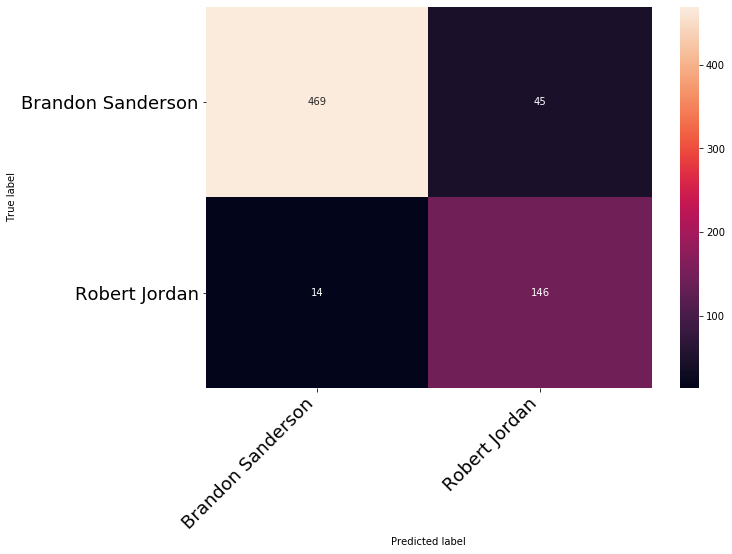

In [68]:
cm = print_confusion_matrix(confusion_matrix(y_true, y_pred), ['Brandon Sanderson', 'Robert Jordan'])
plt.savefig('confusion_wot.pdf')

Overall the results are decent.  It recognizes a significant number of the chapters correctly.  